# Notebook for getting Redhook related tracts and geography

In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
import geopandas as gpd

In [ ]:
redhook = pd.read_csv('new pluto redhook.csv')
redhook.head()

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,latitude,longitude,zonemap,sanborn,taxmap
0,BK,574,32,306,53,1010,15,38,11231,L101,76,4100,3,1D,202 CONOVER STREET,M2-1,K2,5.0,0,NaN,202 CONOVER STREET LLC,2500,4314,4314.0,0.0,0.0,4314.0,0.0,0.0,0.0,0.0,2,0,2.0,0,1,25.00,100.00,25.0,100.0,NaN,1,N,3,0,168750,237600,0,0,2018,0,1.73,0.0,2,0.0,3,3005740032,NaN,53,980120,186237,40.677853,-74.014890,16a,301 002,30207
1,BK,340,25,306,53,1000,15,39,11231,E202,76,4100,3,2C,UNION STREET,M2-1,V1,11.0,0,C,PORT AUTHORITY OF NY AND NJ,2400,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,18.75,100.00,0.0,0.0,NaN,0,Y,5,5,75150,75150,75150,0,0,0,0.00,0.0,2,0.0,3,3003400025,NaN,53,982598,188825,40.684958,-74.005957,16a,301 006,30202
2,BK,346,6,306,53,1000,15,39,11231,E202,76,4100,3,2C,55 HAMILTON AVENUE,M2-1,V9,11.0,0,C,PORT AUTHORITY OF NY AND NJ,1196,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,20.00,67.75,0.0,0.0,NaN,0,Y,5,5,65250,65250,65250,0,0,0,0.00,0.0,2,0.0,3,3003460006,NaN,53,982564,188477,40.684002,-74.006079,16a,301 006,30202
3,BK,541,16,306,53,1024,15,38,11231,L131,76,4100,3,1D,MILL STREET,M1-1,Z9,NaN,1,NaN,581 CLINTON STREET,1786,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,57.00,67.17,0.0,0.0,N,0,Y,3,0,18450,26100,0,0,0,0,0.00,0.0,1,2.4,3,3005410016,NaN,53,983977,185211,40.675038,-74.000984,16c,301 037,30206
4,BK,340,19,306,53,1000,15,39,11231,E202,76,4100,3,2C,22 UNION STREET,M2-1,V1,11.0,0,C,PORT AUTHORITY OF NY AND NJ,2500,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,25.00,100.00,0.0,0.0,NaN,0,Y,5,5,67950,67950,67950,0,0,0,0.00,0.0,2,0.0,3,3003400019,NaN,53,982491,188874,40.685092,-74.006342,16a,301 006,30202


In [ ]:
#Installing necessary geospatial libraries
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
!pip install pyspark
!pip install fiona
!pip install shapely

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1,005 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6

In [ ]:
#Importing needed libraries
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely
import rtree

import pandas as pd
import geopandas as gpd

In [ ]:
#Loading census tract information
nyc_counties = ["005","061","081","085","047"]
spatial_data = gpd.read_file('tl_2019_36_tract.shp')
spatial_data = spatial_data.loc[spatial_data['COUNTYFP'].isin(nyc_counties)]
spatial_data.to_file("census_tracts.json", driver="GeoJSON")

In [ ]:
#Converting to GeoJSON 

#bbls = gpd.read_file('ceqr_bbl.json').to_crs(fiona.crs.from_epsg(2263))
census_tracts = gpd.read_file('census_tracts.json').to_crs(fiona.crs.from_epsg(2263))

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
#Creating rtree indexes for spatial matching of BBLs and Census Tracts
index = rtree.Rtree()
for idx,geometry in enumerate(census_tracts.geometry):
    index.insert(idx, geometry.bounds)

In [ ]:
index.bounds

[912190.8893736254, 113288.79017251907, 1067382.526638073, 273587.03900878486]

In [ ]:
idx

2166

In [ ]:
#Spatial matching of BBLs and Census Tracts

import csv
import pyproj
import shapely.geometry as geom


proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = []

for i, row in redhook.iterrows():
  p = geom.Point(proj(float(row['longitude']), float(row['latitude'])))
  match = None
  for idx in index.intersection((p.x, p.y, p.x, p.y)):
    if census_tracts.geometry[idx].contains(p):
      match = census_tracts.GEOID[idx]
      counts.append(match)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [ ]:
#Creating new column with Census Tract GEOIDs
redhook['GEOID'] = counts
redhook.head()

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,latitude,longitude,zonemap,sanborn,taxmap,GEOID
0,BK,574,32,306,53,1010,15,38,11231,L101,76,4100,3,1D,202 CONOVER STREET,M2-1,K2,5.0,0,NaN,202 CONOVER STREET LLC,2500,4314,4314.0,0.0,0.0,4314.0,0.0,0.0,0.0,0.0,2,0,2.0,0,1,25.00,100.00,25.0,100.0,NaN,1,N,3,0,168750,237600,0,0,2018,0,1.73,0.0,2,0.0,3,3005740032,NaN,53,980120,186237,40.677853,-74.014890,16a,301 002,30207,36047005300
1,BK,340,25,306,53,1000,15,39,11231,E202,76,4100,3,2C,UNION STREET,M2-1,V1,11.0,0,C,PORT AUTHORITY OF NY AND NJ,2400,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,18.75,100.00,0.0,0.0,NaN,0,Y,5,5,75150,75150,75150,0,0,0,0.00,0.0,2,0.0,3,3003400025,NaN,53,982598,188825,40.684958,-74.005957,16a,301 006,30202,36047005300
2,BK,346,6,306,53,1000,15,39,11231,E202,76,4100,3,2C,55 HAMILTON AVENUE,M2-1,V9,11.0,0,C,PORT AUTHORITY OF NY AND NJ,1196,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,20.00,67.75,0.0,0.0,NaN,0,Y,5,5,65250,65250,65250,0,0,0,0.00,0.0,2,0.0,3,3003460006,NaN,53,982564,188477,40.684002,-74.006079,16a,301 006,30202,36047005300
3,BK,541,16,306,53,1024,15,38,11231,L131,76,4100,3,1D,MILL STREET,M1-1,Z9,NaN,1,NaN,581 CLINTON STREET,1786,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,57.00,67.17,0.0,0.0,N,0,Y,3,0,18450,26100,0,0,0,0,0.00,0.0,1,2.4,3,3005410016,NaN,53,983977,185211,40.675038,-74.000984,16c,301 037,30206,36047005300
4,BK,340,19,306,53,1000,15,39,11231,E202,76,4100,3,2C,22 UNION STREET,M2-1,V1,11.0,0,C,PORT AUTHORITY OF NY AND NJ,2500,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0,0,25.00,100.00,0.0,0.0,NaN,0,Y,5,5,67950,67950,67950,0,0,0,0.00,0.0,2,0.0,3,3003400019,NaN,53,982491,188874,40.685092,-74.006342,16a,301 006,30202,36047005300


In [ ]:
redhook.to_csv('redhook_census_tracts.csv')

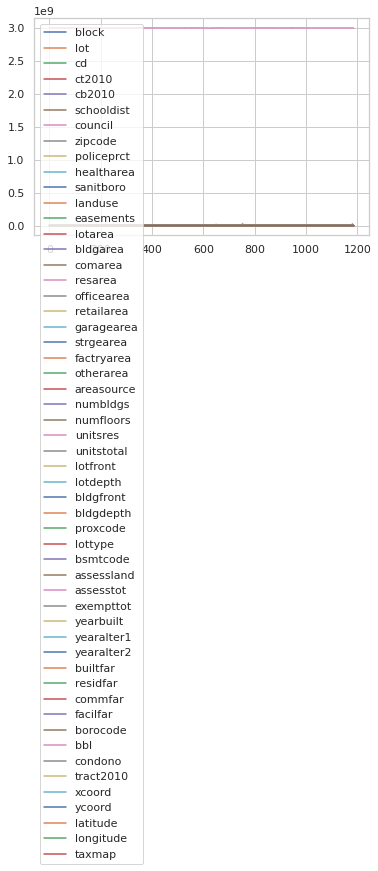